In [1]:
from pathlib import Path
import cantera as ct
import matplotlib.pyplot as plt
%matplotlib inline
import math as math
import numpy as np
import pandas as pd

Stoichiometric mixture, phi = 1

In [15]:
# Inlet Temperature in Kelvin and Inlet Pressure in Pascals
# In this case we are setting the inlet T and P to room temperature conditions
To = 300
Po = 101325

# Define the gas-mixutre and kinetics
# In this case, we are choosing a GRI3.0 gas
#gas = ct.Solution("gri30.yaml")
gas = ct.Solution('Jerzembeck.yaml')

# Create a stoichiometric CH4/Air premixed mixture
#gas.set_equivalence_ratio(1.0, "CH4", {"O2": 1.0, "N2": 3.76})
gas.set_equivalence_ratio(1, 'IXC8H18', 'O2:12.5, N2:47')
gas.TP = To, Po

In [17]:
# Domain width in metres
width = 0.02

# Create the flame object
flame = ct.FreeFlame(gas, width=width)

# Define tolerances for the solver
flame.set_refine_criteria(ratio=3, slope=0.1, curve=0.1)

# Define logging level
loglevel = 1

In [18]:
flame.solve(loglevel=loglevel, auto=True)
Su0 = flame.velocity[0]
print(f"Flame Speed is: {Su0 * 100:.2f} cm/s")


************ Solving on 8 point grid with energy equation enabled ************

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     1.068e-05        6.2
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0002737      4.717
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     1.082e-05      6.854
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0001849      4.881
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps       0.00316      3.071
Attempt Newton solution of steady-state problem...    success.

Problem solved on [9] point grid(s).
Expanding domain to accommodate flame thickness. New width: 0.04 m
##############################################################################
Refining grid in flame.
    New points inserted after grid

Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0001709      4.627
Attempt Newton solution of steady-state problem...    success.

Problem solved on [55] point grid(s).

..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 52 
    to resolve AXC5H10 C2H C2H2 C2H3 C2H3CHO C2H3CO C2H4 C2H5 C2H5O C2H5O2 C2H6 C3H2 C3H3 C3H4XA C3H4XP C3H5O C3H5XA C3H5XT C3H6 C3H8 C4H10 C4H6 C4H7 C4H8X1 C5H10X1 C5H9 C6H11 C6H12X1 CH CH2 CH2CCH2OH CH2CHO CH2CO CH2GSG CH2O CH2OH CH3 CH3CHO CH3CO CH3COCH2 CH3COCH3 CH3O CH3O2 CH3O2H CH3OH CH4 CO CO2 CXC8H17 H H2 H2O H2O2 HCCO HCN HCNO HCO HNCO HNO HO2 HOCHO IC4H8O2HXT IXC3H5CHO IXC3H5CO IXC3H6CO IXC3H7 IXC3H7O2 IXC4H10 IXC4H6OH IXC4H7 IXC4H7O IXC4H7OH IXC4H8 IXC4H9 IXC4H9O2 IXC5H9 IXC8H18 N N2 N2O NCO NEOXC5H11

In [19]:
# Create a dataframe to store sensitivity-analysis data
sensitivities = pd.DataFrame(index=gas.reaction_equations(), columns=["base_case"])
# Set the value of the perturbation
dk = 1e-2

In [20]:
for m in range(gas.n_reactions):
    gas.set_multiplier(1.0)  # reset all multipliers
    gas.set_multiplier(1 + dk, m)  # perturb reaction m

    # Always force loglevel=0 for this
    # Make sure the grid is not refined, otherwise it won't strictly
    # be a small perturbation analysis
    # Turn auto-mode off since the flame has already been solved
    flame.solve(loglevel=0, refine_grid=False, auto=False)

    # The new flame speed
    Su = flame.velocity[0]

    sensitivities.iloc[m, 0] = (Su - Su0) / (Su0 * dk)

# This step is essential, otherwise the mechanism will have been altered
gas.set_multiplier(1.0)

In [21]:
sensitivities.head()

,base_case
2 O + M => O2 + M,0.013814
H2 + O => H + OH,0.084072
H + OH => H2 + O,-0.033804
OH + M => H + O + M,0.014707
H + O + M => OH + M,0.007527


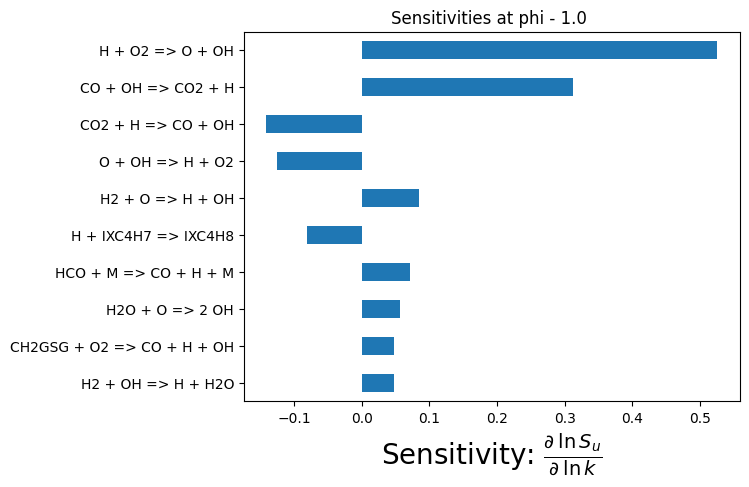

In [28]:
# Reaction mechanisms can contains thousands of elementary steps. Choose a threshold
# to see only the top few
threshold = 0.048

# For plotting, collect only those steps that are above the threshold
# Otherwise, the y-axis gets crowded and illegible
sensitivities_subset = sensitivities[sensitivities["base_case"].abs() > threshold]
reactions_above_threshold = (
    sensitivities_subset.abs().sort_values(by="base_case", ascending=False).index
)
sensitivities_subset.loc[reactions_above_threshold].plot.barh(
    title="Sensitivities at phi - 1.0 ", legend=None
)
plt.gca().invert_yaxis()

plt.rcParams.update({"axes.labelsize": 20})
plt.xlabel(r"Sensitivity: $\frac{\partial\:\ln{S_{u}}}{\partial\:\ln{k}}$");

phi - 0.5

In [29]:
# Inlet Temperature in Kelvin and Inlet Pressure in Pascals
# In this case we are setting the inlet T and P to room temperature conditions
To = 300
Po = 101325

# Define the gas-mixutre and kinetics
# In this case, we are choosing a GRI3.0 gas
#gas = ct.Solution("gri30.yaml")
gas = ct.Solution('Jerzembeck.yaml')

# Create a stoichiometric CH4/Air premixed mixture
#gas.set_equivalence_ratio(1.0, "CH4", {"O2": 1.0, "N2": 3.76})
gas.set_equivalence_ratio(0.5, 'IXC8H18', 'O2:12.5, N2:47')
gas.TP = To, Po

# Domain width in metres
width = 0.02

# Create the flame object
flame = ct.FreeFlame(gas, width=width)

# Define tolerances for the solver
flame.set_refine_criteria(ratio=3, slope=0.1, curve=0.1)

# Define logging level
loglevel = 1

flame.solve(loglevel=loglevel, auto=True)
Su0 = flame.velocity[0]
print(f"Flame Speed is: {Su0 * 100:.2f} cm/s")


************ Solving on 8 point grid with energy equation enabled ************

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0001139      4.576
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps      0.001946      3.944
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps       0.02217      3.004
Attempt Newton solution of steady-state problem...    success.

Problem solved on [9] point grid(s).
Expanding domain to accommodate flame thickness. New width: 0.04 m
##############################################################################
Refining grid in flame.
    New points inserted after grid points 0 1 2 3 4 5 6 7 
    to resolve AXC5H10 C2H2 C2H3 C2H3CHO C2H4 C2H5 C2H5O2 C2H6 C3H2 C3H3 C3H4XA C3H4XP C3H5XA C3H5XT C3H6 C3H8 C4H10 C4H6 C4H8X1 CH2 CH2CO CH2O CH2OH CH3 CH3CHO CH3COCH2 CH3COCH3 CH3O CH3O2

Attempt Newton solution of steady-state problem...    success.

Problem solved on [108] point grid(s).

..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 
    to resolve AXC5H10 C2H2 C2H3 C2H3CHO C2H4 C2H5 C2H6 C3H3 C3H4XA C3H4XP C3H5XA C3H5XT C3H6 C4H6 C4H7 C4H8X1 C5H10X1 CH2 CH2CO CH2O CH2OH CH3 CH3CHO CH3O CH3O2 CH3O2H CH3OH CH4 CO H2 H2O H2O2 HCCO HCO HO2 HOCHO IXC3H5CHO IXC3H6CO IXC3H7 IXC3H7O2 IXC4H10 IXC4H6OH IXC4H7 IXC4H7OH IXC4H8 IXC4H9 IXC4H9O2 IXC5H9 IXC8H18 N2 O OH TXC4H9 TXC4H9O2 XXC7H13 YXC7H14 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...   

In [30]:
# Create a dataframe to store sensitivity-analysis data
sensitivities = pd.DataFrame(index=gas.reaction_equations(), columns=["base_case"])
# Set the value of the perturbation
dk = 1e-2
for m in range(gas.n_reactions):
    gas.set_multiplier(1.0)  # reset all multipliers
    gas.set_multiplier(1 + dk, m)  # perturb reaction m

    # Always force loglevel=0 for this
    # Make sure the grid is not refined, otherwise it won't strictly
    # be a small perturbation analysis
    # Turn auto-mode off since the flame has already been solved
    flame.solve(loglevel=0, refine_grid=False, auto=False)

    # The new flame speed
    Su = flame.velocity[0]

    sensitivities.iloc[m, 0] = (Su - Su0) / (Su0 * dk)

# This step is essential, otherwise the mechanism will have been altered
gas.set_multiplier(1.0)

sensitivities.head()


,base_case
2 O + M => O2 + M,-0.001463
H2 + O => H + OH,0.017451
H + OH => H2 + O,-0.005994
OH + M => H + O + M,-0.003189
H + O + M => OH + M,-0.001719


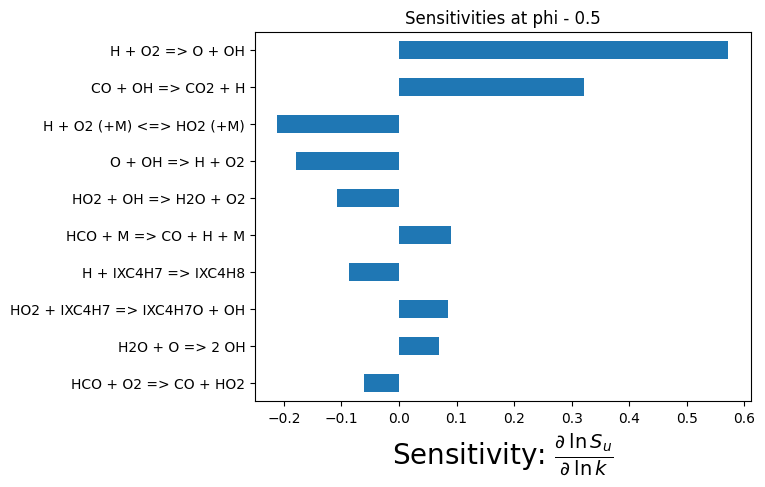

In [31]:
# Reaction mechanisms can contains thousands of elementary steps. Choose a threshold
# to see only the top few
threshold = 0.06

# For plotting, collect only those steps that are above the threshold
# Otherwise, the y-axis gets crowded and illegible
sensitivities_subset = sensitivities[sensitivities["base_case"].abs() > threshold]
reactions_above_threshold = (
    sensitivities_subset.abs().sort_values(by="base_case", ascending=False).index
)
sensitivities_subset.loc[reactions_above_threshold].plot.barh(
    title="Sensitivities at phi - 0.5", legend=None
)
plt.gca().invert_yaxis()

plt.rcParams.update({"axes.labelsize": 20})
plt.xlabel(r"Sensitivity: $\frac{\partial\:\ln{S_{u}}}{\partial\:\ln{k}}$");

phi = 1.5

In [32]:
# Inlet Temperature in Kelvin and Inlet Pressure in Pascals
# In this case we are setting the inlet T and P to room temperature conditions
To = 300
Po = 101325

# Define the gas-mixutre and kinetics
# In this case, we are choosing a GRI3.0 gas
#gas = ct.Solution("gri30.yaml")
gas = ct.Solution('Jerzembeck.yaml')

# Create a stoichiometric CH4/Air premixed mixture
#gas.set_equivalence_ratio(1.0, "CH4", {"O2": 1.0, "N2": 3.76})
gas.set_equivalence_ratio(1.5, 'IXC8H18', 'O2:12.5, N2:47')
gas.TP = To, Po

# Domain width in metres
width = 0.02

# Create the flame object
flame = ct.FreeFlame(gas, width=width)

# Define tolerances for the solver
flame.set_refine_criteria(ratio=3, slope=0.1, curve=0.1)

# Define logging level
loglevel = 1

flame.solve(loglevel=loglevel, auto=True)
Su0 = flame.velocity[0]
print(f"Flame Speed is: {Su0 * 100:.2f} cm/s")


************ Solving on 8 point grid with energy equation enabled ************

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     7.119e-06      7.624
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0001216      4.083
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0006928      4.726
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps      1.37e-05      6.649
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     7.802e-05      5.006
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0008887      4.334
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps       0.01012      3.335
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.000

Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0003844      3.792
Attempt Newton solution of steady-state problem...    success.

Problem solved on [68] point grid(s).

..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 
    to resolve AXC5H10 C2H C2H2 C2H3 C2H3CHO C2H4 C2H5 C2H5O2 C2H6 C3H2 C3H3 C3H4XA C3H4XP C3H5O C3H5XA C3H5XT C3H6 C3H8 C4H10 C4H6 C4H7 C4H8X1 C5H10X1 C6H12X1 CH CH2 CH2CCH2OH CH2CHO CH2CO CH2GSG CH2O CH2OH CH3 CH3CHO CH3CO CH3COCH2 CH3COCH3 CH3O CH3O2 CH3O2H CH3OH CH4 CO CO2 CXC8H17 H H2 H2O H2O2 HCCO HCN HCNO HCO HNCO HO2 HOCHO IC4H8O2HXT IXC3H5CHO IXC3H5CO IXC3H6CO IXC3H7 IXC3H7O2 IXC4H10 IXC4H6OH IXC4H7 IXC4H7O IXC4H7OH IXC4H8 IXC4H9 IXC4H9O2 IXC5H9 IXC8H18 N N2 NCO NEOXC5H11 N

In [33]:
# Create a dataframe to store sensitivity-analysis data
sensitivities = pd.DataFrame(index=gas.reaction_equations(), columns=["base_case"])
# Set the value of the perturbation
dk = 1e-2
for m in range(gas.n_reactions):
    gas.set_multiplier(1.0)  # reset all multipliers
    gas.set_multiplier(1 + dk, m)  # perturb reaction m

    # Always force loglevel=0 for this
    # Make sure the grid is not refined, otherwise it won't strictly
    # be a small perturbation analysis
    # Turn auto-mode off since the flame has already been solved
    flame.solve(loglevel=0, refine_grid=False, auto=False)

    # The new flame speed
    Su = flame.velocity[0]

    sensitivities.iloc[m, 0] = (Su - Su0) / (Su0 * dk)

# This step is essential, otherwise the mechanism will have been altered
gas.set_multiplier(1.0)

sensitivities.head()

,base_case
2 O + M => O2 + M,0.006847
H2 + O => H + OH,0.046084
H + OH => H2 + O,-0.005787
OH + M => H + O + M,0.00299
H + O + M => OH + M,0.006984


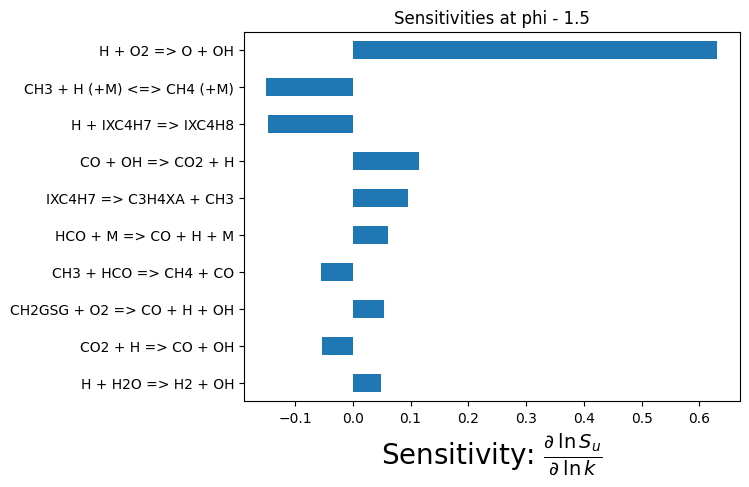

In [34]:
# Reaction mechanisms can contains thousands of elementary steps. Choose a threshold
# to see only the top few
threshold = 0.0493

# For plotting, collect only those steps that are above the threshold
# Otherwise, the y-axis gets crowded and illegible
sensitivities_subset = sensitivities[sensitivities["base_case"].abs() > threshold]
reactions_above_threshold = (
    sensitivities_subset.abs().sort_values(by="base_case", ascending=False).index
)
sensitivities_subset.loc[reactions_above_threshold].plot.barh(
    title="Sensitivities at phi - 1.5", legend=None
)
plt.gca().invert_yaxis()

plt.rcParams.update({"axes.labelsize": 20})
plt.xlabel(r"Sensitivity: $\frac{\partial\:\ln{S_{u}}}{\partial\:\ln{k}}$");